# Introduction

This project uses the Forest Fires dataset from the UCI Machine Learning Repository to predict the burned area (in hectares) after a forest fire. The goal is to build a regression model that can estimate fire impact based on weather conditions, fire indices, and spatial temporal variables.

The dataset includes features such as:

  1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
   2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
   3. month - month of the year: 'jan' to 'dec'
   4. day - day of the week: 'mon' to 'sun'
   5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
   6. DMC - DMC index from the FWI system: 1.1 to 291.3
   7. DC - DC index from the FWI system: 7.9 to 860.6
   8. ISI - ISI index from the FWI system: 0.0 to 56.10
   9. temp - temperature in Celsius degrees: 2.2 to 33.30
   10. RH - relative humidity in %: 15.0 to 100
   11. wind - wind speed in km/h: 0.40 to 9.40
   12. rain - outside rain in mm/m2 : 0.0 to 6.4
   13. area - the burned area of the forest (in ha)


The target variable area is highly skewed and contains many zeros, so we use appropriate preprocessing steps such as **log-transforming** the target and using a stratified split. We compare tree-based models **(Random Forest and GradientBoostRegressor)** to understand how well each can predict burned area.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("forestfires.csv")
df.head(10)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0
5,8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0.0
6,8,6,aug,mon,92.3,88.9,495.6,8.5,24.1,27,3.1,0.0,0.0
7,8,6,aug,mon,91.5,145.4,608.2,10.7,8.0,86,2.2,0.0,0.0
8,8,6,sep,tue,91.0,129.5,692.6,7.0,13.1,63,5.4,0.0,0.0
9,7,5,sep,sat,92.5,88.0,698.6,7.1,22.8,40,4.0,0.0,0.0


In [5]:
df.shape

(517, 13)

The dataset contains 517 rows. The rain feature shows 509 zeros, and the remaining values are extremely small. Because the variable has almost no variation and contributes no meaningful signal, it acts as noise. Therefore, rain is dropped from the analysis.

In [6]:
num_no_rain_days = (df['rain'] == 0).sum()
num_no_rain_days

np.int64(509)

In [7]:
df = df.drop('rain', axis = 1)

The dataset contains no null values, so no imputation is required. All features can be used directly after basic preprocessing.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  area    517 non-null    float64
dtypes: float64(7), int64(3), object(2)
memory usage: 48.6+ KB


# Descriptive Statistics
The descriptive statistics provide an overview of the numerical features Most variables show reasonable ranges and variability. Notably, the target variable area is highly skewed, with a median of 0.00 and a maximum of 1090.84, confirming the presence of many small fires and a few extreme outliers. This indicates that the burned area distribution is heavily right-skewed and will require appropriate handling during modeling.

In [9]:
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,1090.840000


In [10]:
df['month'].unique()

array(['mar', 'oct', 'aug', 'sep', 'apr', 'jun', 'jul', 'feb', 'jan',
       'dec', 'may', 'nov'], dtype=object)

The month column is converted from text labels to numerical values (1–12) to allow easier analysis of seasonal patterns and their relationship with fire occurrence and burned area.

In [11]:
df['month'] = df['month'].replace({'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12})

/tmp/ipython-input-3508438999.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['month'] = df['month'].replace({'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12})


In [12]:
df[['month']]

,month
0,3
1,10
2,10
3,3
4,3
...,...
512,8
513,8
514,8
515,8


In [13]:
correlation_matrix = df.corr(numeric_only=True)
corr = correlation_matrix
corr

,X,Y,month,FFMC,DMC,DC,ISI,temp,RH,wind,area
X,1.000000,0.539548,-0.065003,-0.021039,-0.048384,-0.085916,0.006210,-0.051258,0.085223,0.018798,0.063385
Y,0.539548,1.000000,-0.066292,-0.046308,0.007782,-0.101178,-0.024488,-0.024103,0.062221,-0.020341,0.044873
month,-0.065003,-0.066292,1.000000,0.291477,0.466645,0.868698,0.186597,0.368842,-0.095280,-0.086368,0.056496
FFMC,-0.021039,-0.046308,0.291477,1.000000,0.382619,0.330512,0.531805,0.431532,-0.300995,-0.028485,0.040122
DMC,-0.048384,0.007782,0.466645,0.382619,1.000000,0.682192,0.305128,0.469594,0.073795,-0.105342,0.072994
DC,-0.085916,-0.101178,0.868698,0.330512,0.682192,1.000000,0.229154,0.496208,-0.039192,-0.203466,0.049383
ISI,0.006210,-0.024488,0.186597,0.531805,0.305128,0.229154,1.000000,0.394287,-0.132517,0.106826,0.008258
temp,-0.051258,-0.024103,0.368842,0.431532,0.469594,0.496208,0.394287,1.000000,-0.527390,-0.227116,0.097844
RH,0.085223,0.062221,-0.095280,-0.300995,0.073795,-0.039192,-0.132517,-0.527390,1.000000,0.069410,-0.075519
wind,0.018798,-0.020341,-0.086368,-0.028485,-0.105342,-0.203466,0.106826,-0.227116,0.069410,1.000000,0.012317


# Correelation Marix Summary
The heatmap shows that most features have weak linear correlation with the target variable area, indicating that burned area is not linearly predictable from individual features. Strong correlations are mainly observed within the fire weather indices themselves particularly between DMC and DC, and FFMC and ISI which reflects shared underlying weather conditions. Overall, the low correlation between predictors and area suggests the need for non-linear models such as tree based methods.

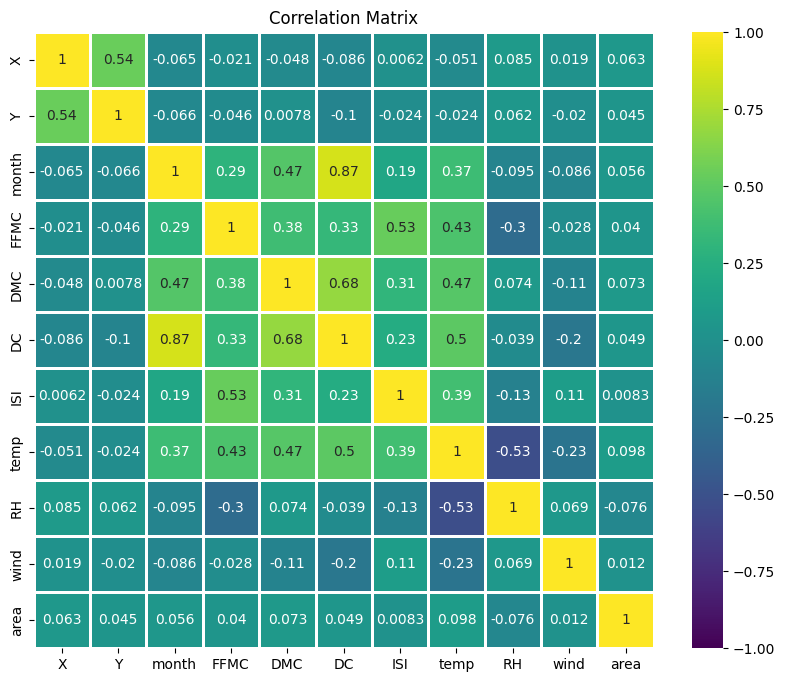

In [14]:
plt.figure(figsize=(10,8))
sns.heatmap(corr, linewidths= 1, annot=True, cmap = "viridis", vmin = -1, vmax = 1)
plt.title('Correlation Matrix')
plt.show()

# Distribution of Key Variables

The histograms show that both temperature and wind follow roughly normal-like distributions with moderate spread. In contrast, the target variable area is extremely right-skewed, with most fires causing zero or very small burned area and only a few cases producing very large values. This confirms that the burned area variable is highly imbalanced and heavy-tailed, which justifies applying transformations such as log1p and using models that can handle skewed targets.

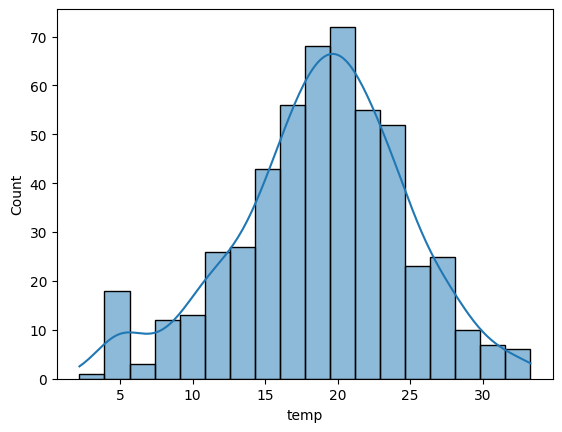

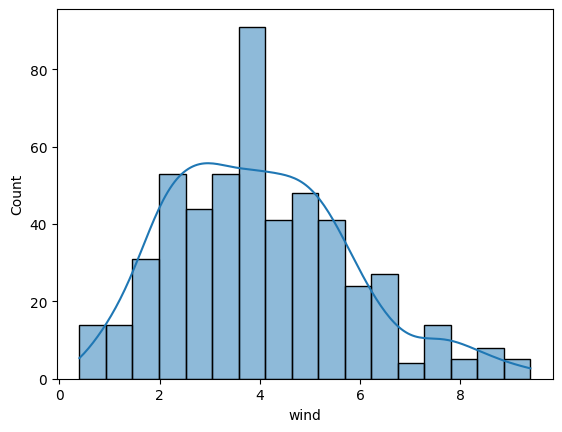

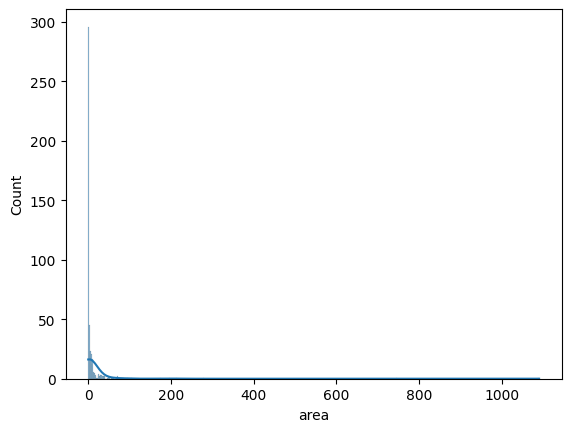

In [15]:
sns.histplot(df['temp'], kde=True)
plt.show()
sns.histplot(df['wind'], kde=True)
plt.show()
plt.show()
sns.histplot(df['area'], kde=True)
plt.show()

# Scatter Plot Analysis

1. **X vs area**

    The X-coordinate shows no clear relationship with burned area. Fires of all sizes occur across the full spatial range.

    Conclusion: X does not predict fire size.

2. **Y vs area**

    The Y-coordinate also shows no meaningful trend. Both small and large fires appear at various Y locations.

    Conclusion: Y has no direct influence on burned area.

3. **month vs area**

    Most non-zero burned areas occur between June and September, but large fires still appear in multiple months.

    Conclusion: Seasonality exists, but month is not a strong predictor of fire size.

4. **day vs area**

    Fires occur across all days of the week with no visible pattern. Large fires are not concentrated on specific days.

    Conclusion: Day of the week has no effect on burned area.

5. **FFMC vs area**

    FFMC values are mostly high (80–95) for all fires, and large fires also occur in this same cluster.

    Conclusion: FFMC shows little variation and does not distinguish small from large fires.

6. **DMC vs area**

    Small fires occur across all DMC values, and a few large fires happen at medium to high DMC levels, but the trend is inconsistent.

    Conclusion: DMC has weak association with larger fires.

6. **DC vs area**

    DC values are generally high across all observations, and large fires appear at many DC levels.

    Conclusion: DC does not show a meaningful relationship with burned area.

7. **ISI vs area**

    Most fires have low ISI, and large fires appear sporadically across different ISI values.

    Conclusion: ISI is not a reliable predictor of fire size.

8. **temp vs area**

    Both low and high temperatures produce mostly small burned areas, with only a few large fires scattered randomly.
    Conclusion: Temperature alone does not explain burned area.

9. **RH vs area**

    Higher humidity corresponds to small fires; a few larger fires occur at lower RH, but the pattern is noisy.

    Conclusion: RH shows a weak inverse trend but is not a strong predictor.

10. **wind vs area**

    Most fires occur at lower wind speeds (1–6 km/h), and the burned area remains small across this entire range. A few large fires occur at moderate wind speeds, but no clear pattern is visible.
    
    Conclusion: Wind speed shows no strong relationship with burned area.



## Overall Conclusion

Across all features, there is no strong linear relationship with the burned area. Large fires are rare and occur at many different feature values. This confirms that the target variable is highly skewed and difficult to model using simple linear patterns, supporting the use of tree-based or regularized models.


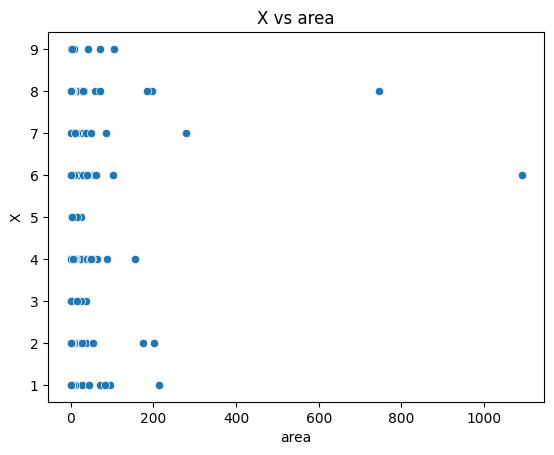

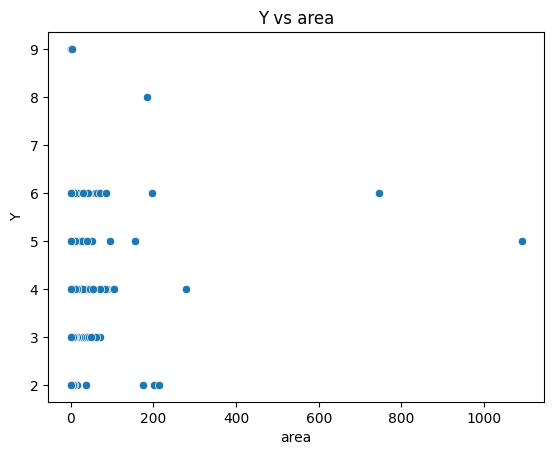

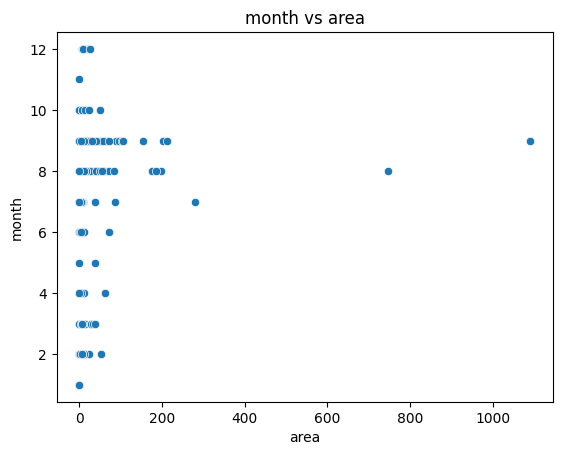

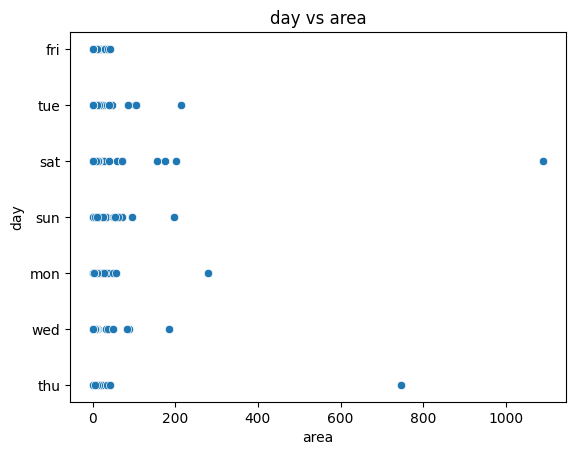

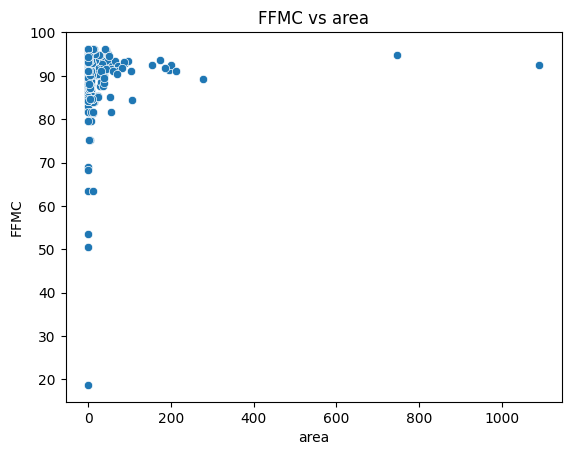

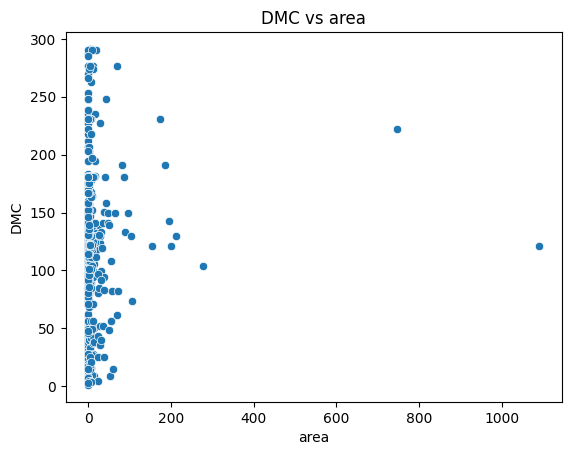

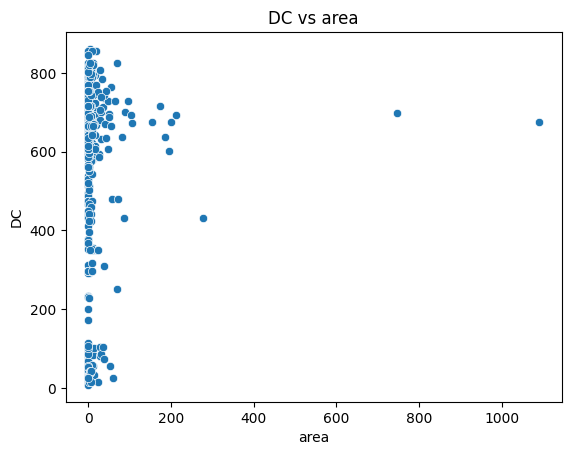

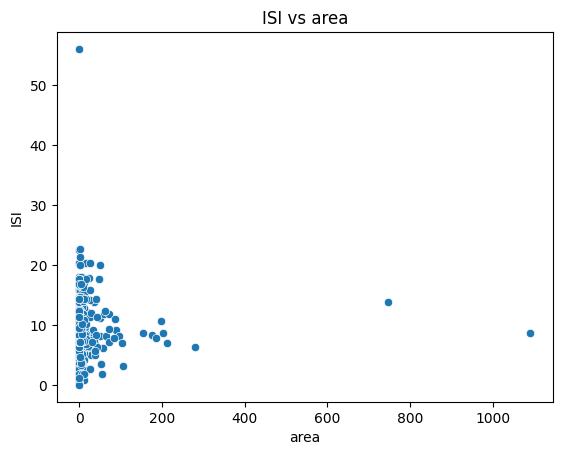

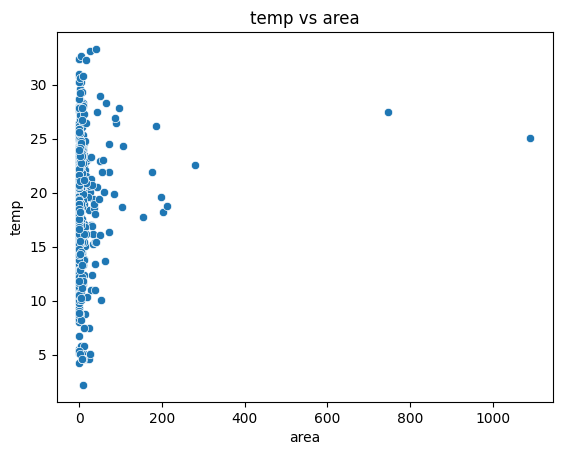

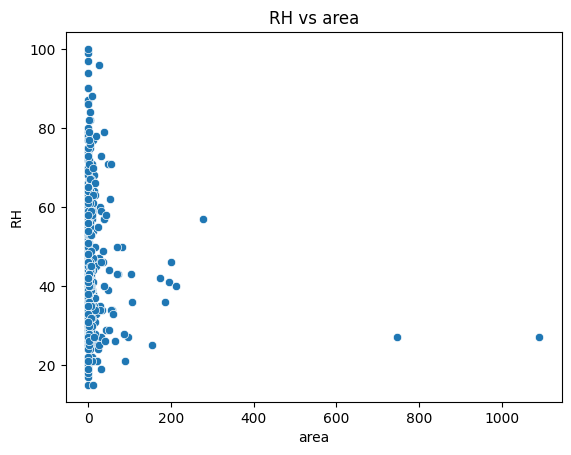

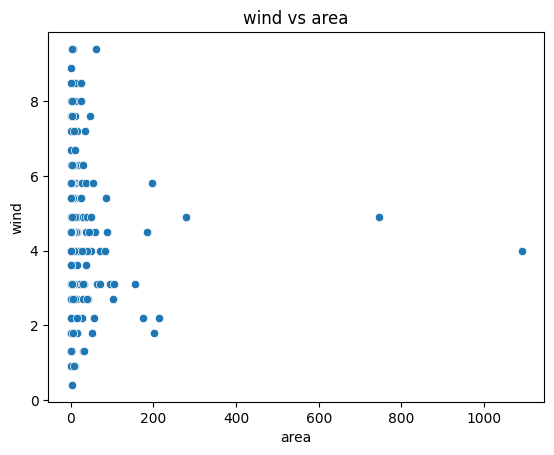

In [16]:
feature_plot = ['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind']
for f in feature_plot:
    sns.scatterplot(data=df, x='area', y=f)
    plt.title(f'{f} vs area')
    plt.show()

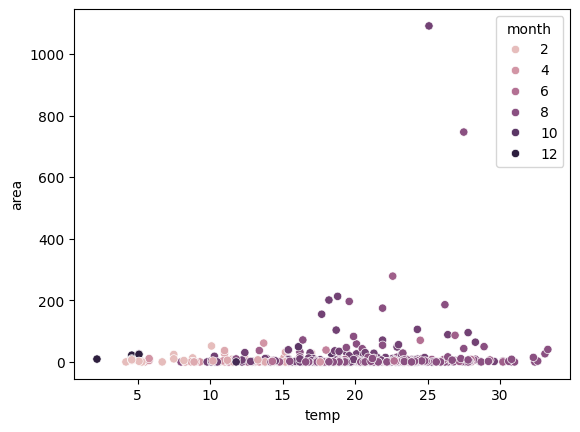

In [17]:
sns.scatterplot(data=df, x='temp', y='area', hue='month')
plt.show()

Here, we have defined the label (y) and the features (X). The features are futher divided into numrical and categorical features.

In [18]:
X = df.drop('area', axis=1)
y = df['area']
features = X.columns

numeriacal_feaures = X.select_dtypes(exclude='object').columns
categorical_features = X.select_dtypes(include='object')

We import necessary libraries for our model.

In [19]:
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import randint

# Train–Test Split with Stratification

We stratify the train–test split using a binary indicator (y > 0) to ensure that both sets contain a similar proportion of zero-area and non-zero fire events. Without this stratification, the test set often ends up with mostly zeros due to the heavy imbalance in area, which leads to unstable evaluation metrics and models that appear to perform poorly.

We initially tried splitting the data without stratification, but the results were inconsistent because the target variable is dominated by zeros. By stratifying, we ensure that the model is trained and evaluated on data that reflect the true distribution of small and non-zero fires, improving the reliability and fairness of the performance metrics.

In [20]:
y_binary = (y > 0).astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y_binary
)

# Log Transformation of the Target

The burned area (area) is highly right skewed and contains many zero values. Most fires burn almost no area, while a few extreme cases burn hundreds of hectares. To stabilize the distribution and reduce the effect of large outliers, we apply a log1p transformation to the target variable.

This transformation helps the model learn more effectively by compressing extreme values and spreading out small positive values, leading to smoother gradients and more stable predictions. After modeling, the predictions are converted back to the original scale using expm1.

In [21]:
use_log_target = True
y_train_model = np.log1p(y_train)
y_test_model = np.log1p(y_test)

# Preprocessing Pipeline

We separate the features into numerical and categorical groups to apply appropriate transformations. Numerical features are standardized using StandardScaler to ensure they are on a comparable scale, which helps regularized linear models and improves gradient based learning. Categorical features are encoded using OneHotEncoder so that tree based and linear models can interpret them properly. These transformations are combined using ColumnTransformer, ensuring consistent preprocessing during both training and prediction.

In [22]:
numerical_features = X.select_dtypes(exclude='object').columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

numerical_preprocessing = StandardScaler()
categorical_preprocessing = OneHotEncoder(handle_unknown='ignore')

preprocessing = ColumnTransformer([
    ('numerical', numerical_preprocessing, numerical_features),
    ('categorical', categorical_preprocessing, categorical_features)
])

# Random Forest Model and Hyperparameter Search

We build a pipeline that applies preprocessing and trains a RandomForestRegressor. A RandomizedSearchCV with 10-fold cross-validation is used to tune key hyperparameters. The parameter grid includes practical ranges for model complexity:

1. n_estimators (number of trees)
2. max_depth (controls how complex each tree can grow)
3. min_samples_leaf (regularization to reduce overfitting)
4. max_features (features considered at each split)

These settings provide a balanced search space without unnecessary computation. We experimented with multiple n_iter values (**50, 40, 35, 25, 20, and 15)**, and found **15 iterations** produced the most stable results. We also tested several cross-validation settings and observed that **KFold with 10 splits** yielded the best overall performance.


In [23]:
RandomFor = make_pipeline(
    preprocessing,
    RandomForestRegressor(random_state=0, n_jobs=-1)
)

param_dist = {
    'randomforestregressor__n_estimators': [100, 300, 500],
    'randomforestregressor__max_depth': [None, 6, 10, 20],
    'randomforestregressor__min_samples_leaf': [1, 2, 4],
    'randomforestregressor__max_features': ['sqrt', 0.3, 0.5]
}

cv = KFold(n_splits=10, shuffle=True, random_state=0)
rf_search = RandomizedSearchCV(RandomFor, param_distributions=param_dist,
                               n_iter=15, cv=cv, scoring='neg_mean_squared_error',
                               n_jobs=-1, random_state=0)
rf_search.fit(X_train, y_train_model)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('numerical',
                                                                               StandardScaler(),
                                                                               ['X',
                                                                                'Y',
                                                                                'month',
                                                                                'FFMC',
                                                                                'DMC',
                                                                                'DC',
                                                                                'ISI',
                                                                                'temp',
                                                                                'RH',
                                                                                'wind']),
                                                                              ('categorical',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['day'])])),
                                             ('randomforestregressor',
                                              RandomForestRegressor(n_jobs=-1,
                                                                    random_state=0))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'randomforestregressor__max_depth': [None,
                                                                             6,
                                                                             10,
                                                                             20],
                                        'randomforestregressor__max_features': ['sqrt',
                                                                                0.3,
                                                                                0.5],
                                        'randomforestregressor__min_samples_leaf': [1,
                                                                                    2,
                                                                                    4],
                                        'randomforestregressor__n_estimators': [100,
                                                                                300,
                                                                                500]},
                   random_state=0, scoring='neg_mean_squared_error')

# Interpretation of Best RandomForest Parameters

The search found that a moderately sized and regularized Random Forest works best:
1. 100 trees = enough to capture patterns without overfitting.
2. max_depth = 6 - shallow trees generalize better on this noisy dataset. more tress would have caused overfitting
3. min_samples_leaf = 1 - deeper leaves can capture small patterns.
4. max_features = 0.5 - using half the features per split reduces tree similarity.

These settings indicate that simpler trees with moderate randomness give the most stable performance for this dataset.

In [24]:
best_RF  = rf_search.best_estimator_

RF_params_df = pd.DataFrame(rf_search.best_params_.items(), columns=["Parameter", "Value"])
RF_params_df

,Parameter,Value
0,randomforestregressor__n_estimators,100.0
1,randomforestregressor__min_samples_leaf,1.0
2,randomforestregressor__max_features,0.5
3,randomforestregressor__max_depth,6.0


# Interpretation of Random Forest Training Metrics

The Random Forest model shows a low training R², but this value is not meaningful for this dataset. The burned area (area) is extremely skewed and dominated by zeros, so the target has very low usable variance. Under these conditions, even small prediction errors cause R² to appear near zero. **This is why R² is not a reliable evaluation metric for this problem.**

The more informative metrics are MSE, RMSE, and MAE.
The model achieves an RMSE of ~58 and an MAE of ~11, which represent the average prediction error in hectares. These values show that the model captures some structure but is limited by the noisy, zero-inflated nature of the target.

**Conclusion:**
Because of the distribution of the target variable, R² and MAPE can be ignored, and RMSE and MAE are the appropriate metrics for evaluating model performance.

In [25]:
y_train_pred = best_RF.predict(X_train)
y_train_pred = np.expm1(y_train_pred) # Inverse transform predictions

RF_train_mse = mean_squared_error(y_train, y_train_pred)
RF_train_r2 = r2_score(y_train, y_train_pred)
RF_train_rmse = np.sqrt(RF_train_mse)
RF_train_mae = mean_absolute_error(y_train, y_train_pred)

RF_training_evaluation = pd.DataFrame({
    'Metric': ['R²', 'MSE', 'RMSE', 'MAE'],
    'Train': [RF_train_r2, RF_train_mse, RF_train_rmse, RF_train_mae,]
})
RF_training_evaluation

,Metric,Train
0,R²,0.077970
1,MSE,3407.776364
2,RMSE,58.376163
3,MAE,11.113260


# Interpretation of Random Forest Test Metrics

The Random Forest model shows a negative R² (-0.028) on the test set, but just like with the training results R² is not meaningful for this dataset because the target variable is dominated by zeros and has extremely low variance. Small errors lead to large swings in R², so this metric can be ignored.

The useful metrics are RMSE and MAE:
1. Train RMSE ≈ 58 vs Test RMSE ≈ 74
2. Train MAE ≈ 11 vs Test MAE ≈ 15.5

The test errors are slightly higher than the training errors, which is expected and indicates mild generalization loss, but no severe overfitting. The difference is reasonable given the noisy and highly skewed nature of the burned-area variable.

As before, MAPE is meaningless because division by zero makes it explode.

**Conclusion**
1. The Random Forest model generalizes reasonably, with test MAE only slightly higher than train MAE.
2. R² and MAPE should be ignored, as they do not reflect true performance for this dataset.
3. RMSE and MAE show that the model captures some signal, but predicting burned area remains difficult due to extreme skew, many zeros, and high randomness in the target.

In [26]:
y_test_pred = rf_search.predict(X_test)
y_test_pred = np.expm1(y_test_pred) # Inverse transform predictions

RF_test_r2 = r2_score(y_test, y_test_pred)
RF_test_mse = mean_squared_error(y_test, y_test_pred)
RF_test_rmse = np.sqrt(RF_test_mse) # Corrected to use RF_test_mse
RF_test_mae = mean_absolute_error(y_test, y_test_pred)

RF_test_evaluation = pd.DataFrame({
    'Metric': ['R²', 'MSE', 'RMSE', 'MAE'],
    'Test': [RF_test_r2, RF_test_mse, RF_test_rmse, RF_test_mae]
})

RF_test_evaluation

,Metric,Test
0,R²,-0.028667
1,MSE,5576.999628
2,RMSE,74.679312
3,MAE,15.531770


In [27]:
RF_training_testing_evaluation_df = pd.DataFrame({
    'Metric':['R²', 'MSE', 'RMSE', 'MAE'],
    'Train': [RF_train_r2, RF_train_mse, RF_train_rmse, RF_train_mae],
    'Test': [RF_test_r2, RF_test_mse, RF_test_rmse, RF_test_mae]
})
RF_training_testing_evaluation_df

,Metric,Train,Test
0,R²,0.077970,-0.028667
1,MSE,3407.776364,5576.999628
2,RMSE,58.376163,74.679312
3,MAE,11.113260,15.531770


In [28]:
RF_training_testing_evaluation_df = RF_training_testing_evaluation_df[RF_training_testing_evaluation_df['Metric'] != 'R²']
RF_training_testing_evaluation_df

,Metric,Train,Test
1,MSE,3407.776364,5576.999628
2,RMSE,58.376163,74.679312
3,MAE,11.113260,15.531770


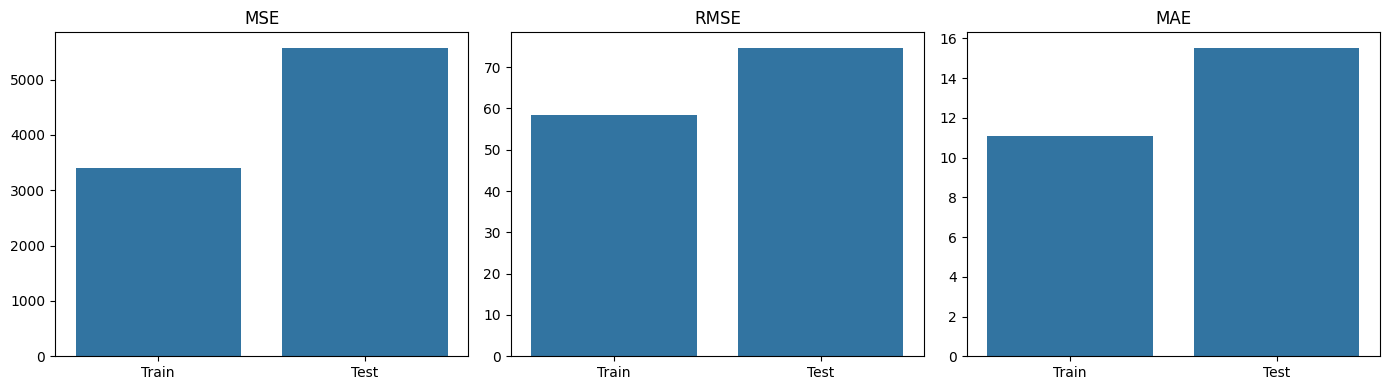

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

sns.barplot(ax=axes[0], x=["Train", "Test"], y=[RF_train_mse, RF_test_mse])
axes[0].set_title("MSE")

sns.barplot(ax=axes[1], x=["Train", "Test"], y=[RF_train_rmse, RF_test_rmse])
axes[1].set_title("RMSE")

sns.barplot(ax=axes[2], x=["Train", "Test"], y=[RF_train_mae, RF_test_mae])
axes[2].set_title("MAE")

plt.tight_layout()
plt.show()

### Feature Importance - Random Forest

1. Temperature is the strongest predictor, indicating that hotter conditions are closely associated with increased fire intensity and burned area.
2. Key fire-weather indices — DMC, RH, DC, ISI, FFMC — also have high importance, showing that fuel moisture, dryness, and atmospheric conditions are major contributors to fire spread.
3. Wind and spatial coordinates (X, Y) have moderate influence; they affect fire behavior but less than fuel and weather factors.
4. Month and day-of-week categories show minimal importance, suggesting that temporal or calendar-related patterns do not significantly influence fire size in this dataset.
5. Overall, the model relies mainly on environmental and meteorological features, which aligns with known physical drivers of wildfire behavior.


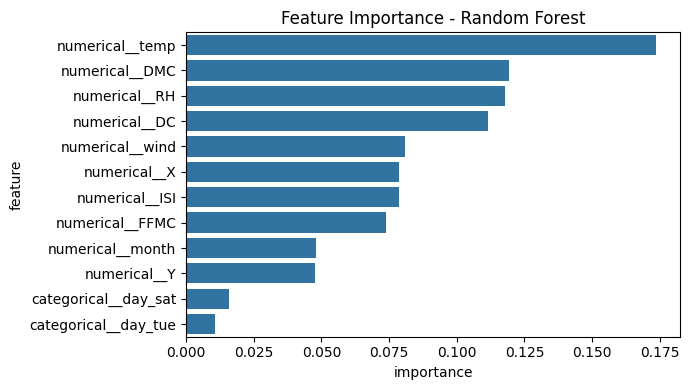

In [30]:
ct = best_RF.named_steps["columntransformer"]
feat_names = ct.get_feature_names_out()

# Extract importances
rf = best_RF.named_steps["randomforestregressor"]
importances = rf.feature_importances_

imp_df = (
    pd.DataFrame({"feature": feat_names, "importance": importances})
    .sort_values("importance", ascending=False)
)

plt.figure(figsize=(7,4))
sns.barplot(data=imp_df.head(12), x="importance", y="feature")
plt.title("Feature Importance - Random Forest")
plt.tight_layout()
plt.show()

# Inference:
1. Most residuals lie above zero, meaning the model underpredicts burned area for many cases.
2. The majority of predictions are between 0 and 5, which explains why residuals are large for cases where actual area is much higher.
3. A few large residuals (50–120+) indicate that the model struggles with rare extreme fire events, which is expected given the highly skewed distribution.
4. No strong pattern (curve, funnel) is visible in the residual cloud, meaning there is no systematic model bias across the predicted range—just difficulty with large fires.

**Conclusion:**
The model predicts small and moderate fire areas reasonably well but cannot capture extreme burned-area values, which dominate the residuals.

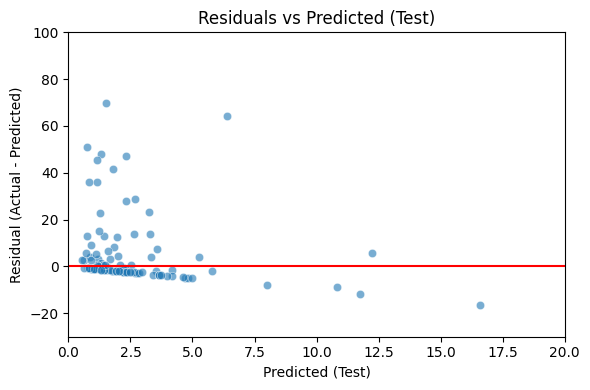

In [31]:
y_test_pred = np.expm1(best_RF.predict(X_test))
residuals = y_test - y_test_pred

plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test_pred, y=residuals, alpha=0.6)

# rescale to see 99% of points clearly
plt.ylim(-30, 100)
plt.xlim(0, 20)

plt.axhline(0, color="red", linestyle="-")
plt.xlabel("Predicted (Test)")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted (Test)")
plt.tight_layout()
plt.show()

# Inference:
1. The points cluster heavily near the bottom-left, showing that most fires in the dataset are very small (0–5 hectares).
2. Many points lie below the diagonal, meaning the model underpredicts actual fire size—especially for cases with actual area > 5 hectares.
3. For larger burned areas (5–20 ha), predictions remain low, indicating that the model fails to capture moderate and large fires, likely due to their rarity in the dataset.
4. No points lie near the diagonal for higher actual values, reinforcing that the model compresses predictions toward small numbers.

**Conclusion:**
The Random Forest model performs reasonably for small fires but systematically underestimates larger fires, which dominate the model’s error due to extreme skew in the target distribution and very few large-fire examples to learn from.

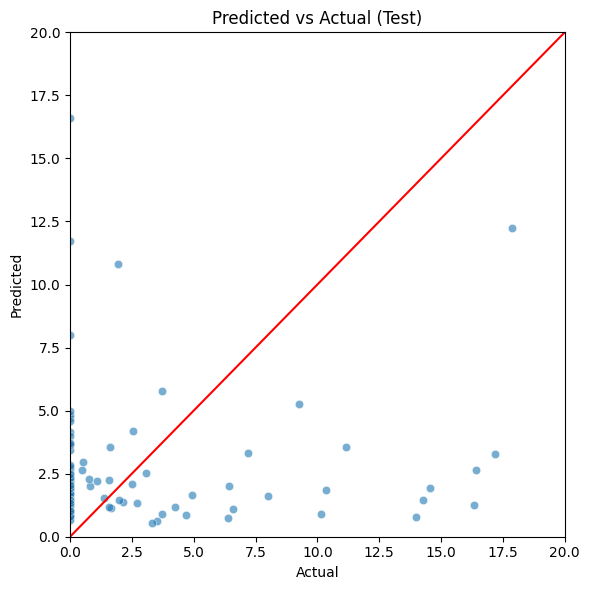

In [32]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)

# rescale to ignore extreme outliers, show main pattern
plt.xlim(0, 20)
plt.ylim(0, 20)

# add 45-degree line
plt.plot([0, 50], [0, 50], 'r-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual (Test)")
plt.tight_layout()
plt.show()

**Gradient Boosting Regressor (GBR) — hyperparameter search**

We run a RandomizedSearchCV over a GradientBoostingRegressor (inside the same preprocessing pipeline) to tune learning rate, number of trees, tree depth and subsampling.
These hyperparameters control the bias–variance tradeoff:
1. learning_rate vs n_estimators: smaller learning rate means we need more trees but usually better generalization.
2. max_depth: limits tree complexity (shallow = more regularization).
3. subsample: <1.0 adds stochasticity (reduces overfitting).

**The search uses 10-fold KFold (shuffled, deterministic) and returns the best estimator for final evaluation.**

In [34]:
GBR_pipe = make_pipeline(
    preprocessing,
    GradientBoostingRegressor(random_state=0)
)

param_grid = {
    'gradientboostingregressor__n_estimators': [100, 200, 300, 500],
    'gradientboostingregressor__learning_rate': [0.01, 0.05, 0.1],
    'gradientboostingregressor__max_depth': [2, 3, 4, 5],
    'gradientboostingregressor__subsample': [0.7, 0.8, 1.0]
}

GBR_search = RandomizedSearchCV(
    make_pipeline(preprocessing, GradientBoostingRegressor(random_state=0)),
    param_distributions=param_grid,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv= KFold(n_splits=10, shuffle=True, random_state=0),
    random_state=0,
    n_jobs=-1,
    verbose=1
)

GBR_search.fit(X_train, y_train_model)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('numerical',
                                                                               StandardScaler(),
                                                                               ['X',
                                                                                'Y',
                                                                                'month',
                                                                                'FFMC',
                                                                                'DMC',
                                                                                'DC',
                                                                                'ISI',
                                                                                'temp',
                                                                                'RH',
                                                                                'wind']),
                                                                              ('categorical',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['day'])])),
                                             ('gradientboostingregressor',
                                              GradientBoostingRegressor(random_state=0))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'gradientboostingregressor__learning_rate': [0.01,
                                                                                     0.05,
                                                                                     0.1],
                                        'gradientboostingregressor__max_depth': [2,
                                                                                 3,
                                                                                 4,
                                                                                 5],
                                        'gradientboostingregressor__n_estimators': [100,
                                                                                    200,
                                                                                    300,
                                                                                    500],
                                        'gradientboostingregressor__subsample': [0.7,
                                                                                 0.8,
                                                                                 1.0]},
                   random_state=0, scoring='neg_mean_squared_error', verbose=1)

# Interpretation of Best GBR Hyperparameters

The search selected a conservative, highly regularized Gradient Boosting model:
1. **n_estimators = 300**
A relatively large number of boosting stages. With a small learning rate, more trees are needed to build the model gradually.
2. **learning_rate = 0.01**
A low learning rate forces the model to learn slowly and carefully. This reduces overfitting and is common for noisy datasets.
3. **max_depth = 2**
Very shallow trees. This means each boosting stage captures only simple patterns, improving generalization and preventing the model from memorizing noise.
4. **subsample = 1.0**
Full dataset used for each boosting stage. Using subsample < 1.0 adds randomness, but here the model performed best with no subsampling.

**Inference:**
These hyperparameters indicate that strong regularization (small trees, small learning rate) works best for this dataset. The burned area target is noisy and extremely imbalanced, so a slow-learning, simple model generalizes better than deeper or more aggressive boosting configurations.

In [35]:
best_GBR = GBR_search.best_estimator_

GBR_params_df = pd.DataFrame(GBR_search.best_params_.items(), columns=["Parameter", "Value"])
GBR_params_df

,Parameter,Value
0,gradientboostingregressor__subsample,1.00
1,gradientboostingregressor__n_estimators,300.00
2,gradientboostingregressor__max_depth,2.00
3,gradientboostingregressor__learning_rate,0.01


# Interpretation of Gradient Boosting Training Metrics

The Gradient Boosting model shows a very low R² (~0.0086) on the training set. This is expected and not meaningful because the burned-area target is extremely skewed and dominated by zeros. Small prediction differences drive R² close to zero, so we ignore R² for this dataset.

The meaningful metrics are MSE, RMSE, and MAE:
1. MSE ≈ 3663.94
This reflects the squared error and is heavily influenced by the few very large fires in the dataset. Because squared error penalizes large mistakes strongly, MSE becomes large even if most predictions are close.
2. RMSE ≈ 60.53
On average, errors are around 60 hectares when considering rare large fires.
3. MAE ≈ 11.95
This shows the typical error for the majority of smaller fires and is a more practical measure of performance.

**Overall, the model captures some pattern but cannot fully predict burned area due to the noisy, zero-inflated nature of the target. The errors are similar to Random Forest, indicating comparable performance.**

**Conclusion:**
For this dataset, RMSE and MAE are the correct evaluation metrics. R² and MAPE are not meaningful, and MSE appears large mainly because of a few extreme outliers.

In [36]:
GBR_y_train_pred_log = best_GBR.predict(X_train)
GBR_y_train_pred     = np.expm1(GBR_y_train_pred_log)

GBR_y_train_r2  = r2_score(y_train, GBR_y_train_pred)
GBR_y_train_mse = mean_squared_error(y_train, GBR_y_train_pred)
GBR_y_train_rmse= np.sqrt(GBR_y_train_mse)
GBR_y_train_mae = mean_absolute_error(y_train, GBR_y_train_pred)

GBR_y_train_df = pd.DataFrame({
    "Metric": ["R²", "MSE", "RMSE", "MAE"],
    "GBR_Train": [GBR_y_train_r2, GBR_y_train_mse, GBR_y_train_rmse, GBR_y_train_mae]
})
GBR_y_train_df

,Metric,GBR_Train
0,R²,0.008662
1,MSE,3663.935883
2,RMSE,60.530454
3,MAE,11.946150


# Interpretation of Gradient Boosting Test Metrics

The Gradient Boosting model shows a negative R² (-0.029) on the test set.
As with the training results, this does not indicate poor learning — it happens because the burned area target is dominated by zeros and has extremely low variance. In such cases, R² becomes unstable and should be ignored.

The meaningful metrics are MSE, RMSE, and MAE:
1. Test MSE ≈ 5579
Larger than train MSE because squared error heavily penalizes the few large fires in the test set.
2. Test RMSE ≈ 74.70
Higher than train RMSE (~60), which is expected due to generalization error and because some large-fire cases appear in the test split.
3. Test MAE ≈ 15.46
Slightly higher than the train MAE (~11.95), indicating mild overfitting but still reasonably close.

**Comparison with Training Results**
1. Train MAE ≈ 11.95

    Test MAE ≈ 15.46
2. Train RMSE ≈ 60.53

    Test RMSE ≈ 74.70

The differences are moderate, not extreme.
This means the model generalizes reasonably well given the difficulty of the problem.

**Conclusion**
1. R² is unreliable due to the zero-inflated target and should be ignored.
2. RMSE and MAE show that GBR performs similarly to Random Forest: it learns some structure but cannot predict the rare extreme fires accurately.
3. The increase in test error is normal and indicates no severe overfitting, just the inherent difficulty of predicting burned area

In [37]:
GBR_y_test_pred_log = best_GBR.predict(X_test)
GBR_y_test_pred     = np.expm1(GBR_y_test_pred_log)

GBR_y_test_r2  = r2_score(y_test, GBR_y_test_pred)
GBR_y_test_mse = mean_squared_error(y_test, GBR_y_test_pred)
GBR_y_test_rmse= np.sqrt(GBR_y_test_mse)
GBR_y_test_mae = mean_absolute_error(y_test, GBR_y_test_pred)

GBR_y_test_df = pd.DataFrame({
    "Metric": ["R²", "MSE", "RMSE", "MAE"],
    "GBR_Test": [GBR_y_test_r2, GBR_y_test_mse, GBR_y_test_rmse, GBR_y_test_mae]
})
GBR_y_test_df

,Metric,GBR_Test
0,R²,-0.029116
1,MSE,5579.431366
2,RMSE,74.695591
3,MAE,15.460554


In [39]:
GBR_training_testing_evaluation_df = pd.DataFrame({
    'Metric':['R²', 'MSE', 'RMSE', 'MAE'],
    "GBR_Train": [GBR_y_train_r2, GBR_y_train_mse, GBR_y_train_rmse, GBR_y_train_mae],
    'GBR_Test': [GBR_y_test_r2, GBR_y_test_mse, GBR_y_test_rmse, GBR_y_test_mae]
})
GBR_training_testing_evaluation_df

,Metric,GBR_Train,GBR_Test
0,R²,0.008662,-0.029116
1,MSE,3663.935883,5579.431366
2,RMSE,60.530454,74.695591
3,MAE,11.946150,15.460554


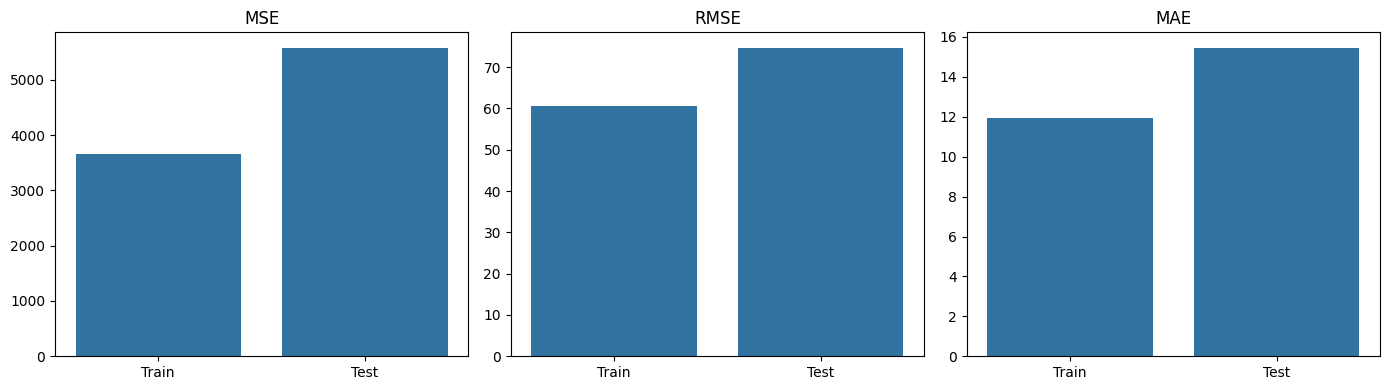

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

sns.barplot(ax=axes[0], x=["Train", "Test"], y=[GBR_y_train_mse, GBR_y_test_mse])
axes[0].set_title("MSE")

sns.barplot(ax=axes[1], x=["Train", "Test"], y=[GBR_y_train_rmse, GBR_y_test_rmse])
axes[1].set_title("RMSE")

sns.barplot(ax=axes[2], x=["Train", "Test"], y=[GBR_y_train_mae, GBR_y_test_mae])
axes[2].set_title("MAE")

plt.tight_layout()
plt.show()

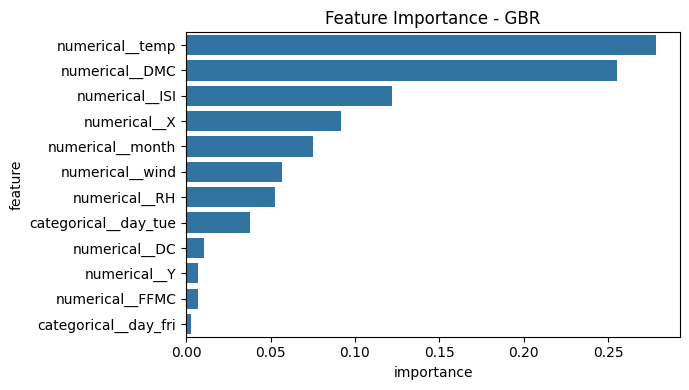

In [43]:
bt = best_GBR.named_steps["columntransformer"]
feat_names = ct.get_feature_names_out()

# Extract importances
GBR = best_GBR.named_steps["gradientboostingregressor"]
importances = GBR.feature_importances_

imp_df = (
    pd.DataFrame({"feature": feat_names, "importance": importances})
    .sort_values("importance", ascending=False)
)

plt.figure(figsize=(7,4))
sns.barplot(data=imp_df.head(12), x="importance", y="feature")
plt.title("Feature Importance - GBR")
plt.tight_layout()
plt.show()

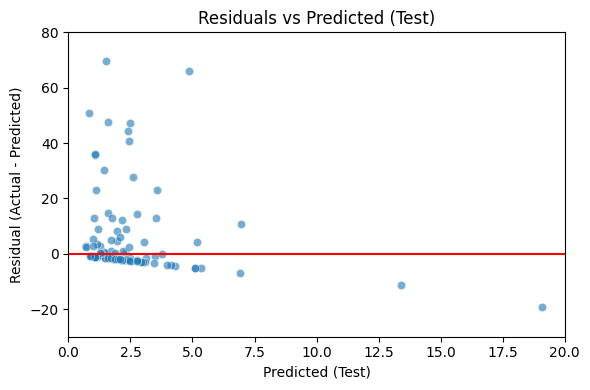

In [45]:
y_test_pred = np.expm1(best_GBR.predict(X_test))
residuals = y_test - y_test_pred

plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test_pred, y=residuals, alpha=0.6)

# rescale to see 99% of points clearly
plt.ylim(-30, 80)
plt.xlim(0, 20)

plt.axhline(0, color="red", linestyle="-")
plt.xlabel("Predicted (Test)")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted (Test)")
plt.tight_layout()
plt.show()

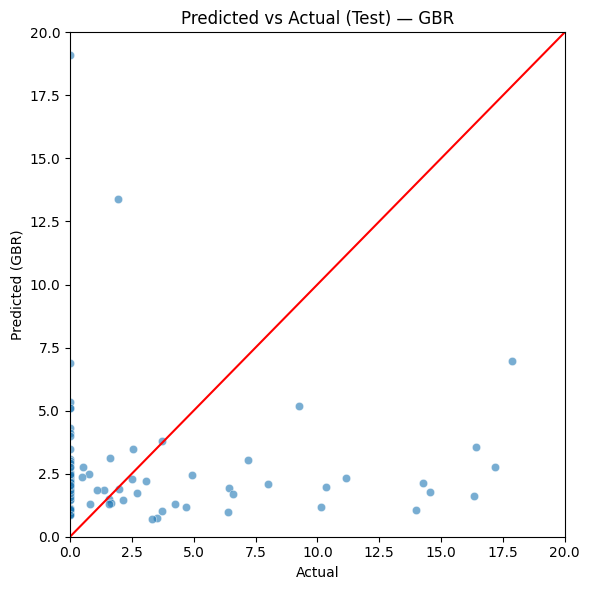

In [49]:
GBR_y_test_pred = np.expm1(best_GBR.predict(X_test))

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=GBR_y_test_pred, alpha=0.6)

plt.xlim(0, 20)
plt.ylim(0, 20)


plt.plot([0, 20], [0, 20], 'r-')

plt.xlabel("Actual")
plt.ylabel("Predicted (GBR)")
plt.title("Predicted vs Actual (Test) — GBR")
plt.tight_layout()
plt.show()

# **Final Model Conclusion**

Based on the test results, **Random Forest performs better than Gradient Boosting.** It achieves lower RMSE and MAE, making it more accurate and stable on unseen data.

Why Random Forest Wins
1. Produces smaller errors on the test set.
2. Handles the noisy, zero-heavy target better by averaging many trees.
3. Less sensitive to hyperparameters and more robust to irregular patterns.

Probable reasons for Underperformance of GBR
1. Boosting can amplify noise when the target has many zeros and a few extreme values.
2. More sensitive to learning rate and depth settings, making it harder to tune for this dataset.

# **Conclusion**

**Random Forest is the more reliable model for predicting burned area. GBR learns some structure but struggles with the dataset’s skewness and noise.**

# Interpretation of Predictions

The model consistently predicts small values (approximately 1 to 4 ha), reflecting its bias toward the majority of the dataset where most fires are small. It significantly underpredicts larger fires due to the limited number of large-fire examples. The model also produces small positive predictions even when the actual area is zero, resulting in false positives. Overall, it performs reasonably on small fires but struggles with medium and large fires because of dataset imbalance and the distribution of the target variable.

In [78]:
def compare_random_predictions(model, X_test, y_test, n=10):

    samples = X_test.sample(n, random_state=1)

    # predictions (inverse log transform)
    preds = np.expm1(model.predict(samples))

    # actual values
    actuals = y_test.loc[samples.index]


    df = pd.DataFrame({
        "sample_index": samples.index,
        "predicted_area": preds,
        "actual_area": actuals.values
    })

    return df.reset_index(drop=True)

# get 10 random predictions
comparison_df = compare_random_predictions(best_RF, X_test, y_test, n=10)
comparison_df

,sample_index,predicted_area,actual_area
0,223,1.148386,37.02
1,245,2.303363,0.76
2,369,4.828557,0.00
3,514,3.565114,11.16
4,47,2.052329,0.00
5,401,1.669353,4.95
6,72,0.779434,0.00
7,446,1.320376,0.00
8,493,1.809150,43.32
9,284,1.285916,24.24


# Interpretation of Sample Level Prediction Errors

The table compares predicted vs actual burned area for random test samples, along with absolute error and percentage error. Several key patterns emerge:

Model performs reasonably on small/medium fires (actual < ~20 ha)

In [79]:
def prediction_error_table(model, X_test, y_test, n=10):
    # pick random samples
    samples = X_test.sample(n, random_state=42)

    # predictions
    preds = np.expm1(model.predict(samples))

    # actual values
    actuals = y_test.loc[samples.index]

    # build table
    df = pd.DataFrame({
        "sample_index": samples.index,
        "predicted_area": preds,
        "actual_area": actuals.values
    })

    # compute errors
    df["absolute_error"] = abs(df["actual_area"] - df["predicted_area"])
    df["percentage_error"] = (df["absolute_error"] / (df["actual_area"] + 1e-9)) * 100

    return df.reset_index(drop=True)

error_df = prediction_error_table(best_RF, X_test, y_test, n=10)
error_df

,sample_index,predicted_area,actual_area,absolute_error,percentage_error
0,430,3.658293,0.00,3.658293,3.658293e+11
1,207,3.278691,17.20,13.921309,8.093784e+01
2,25,1.229251,0.00,1.229251,1.229251e+11
3,72,0.779434,0.00,0.779434,7.794340e+10
4,313,3.980476,0.00,3.980476,3.980476e+11
5,487,2.655897,16.40,13.744103,8.380551e+01
6,88,11.741873,0.00,11.741873,1.174187e+12
7,504,2.341119,49.59,47.248881,9.527905e+01
8,168,4.173418,2.53,1.643418,6.495725e+01
9,311,1.453575,14.29,12.836425,8.982803e+01


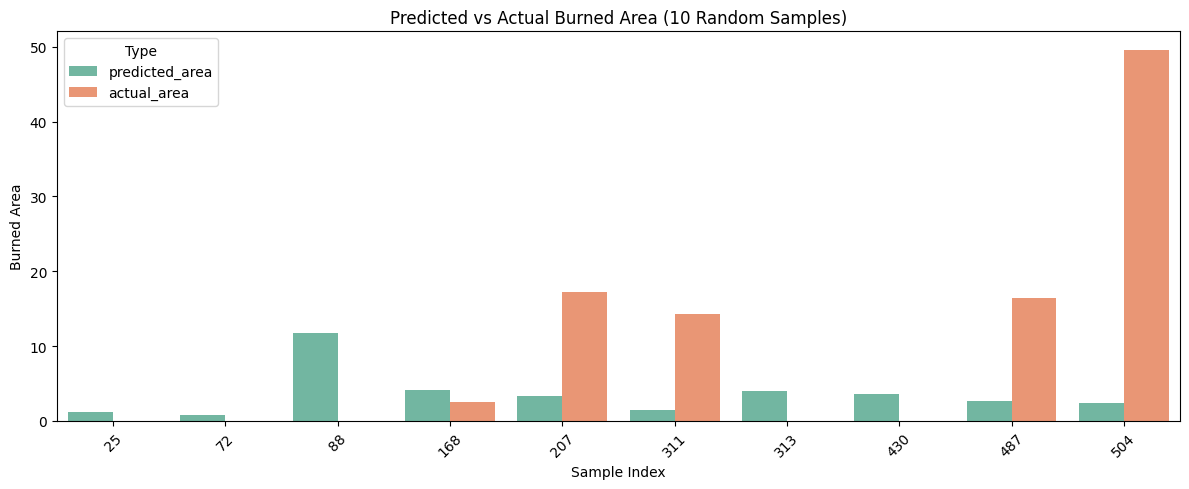

In [84]:
plt.figure(figsize=(12,5))

bar_df = error_df.melt(
    id_vars="sample_index",
    value_vars=["predicted_area", "actual_area"],
    var_name="Type",
    value_name="Area"
)

sns.barplot(data=bar_df, x="sample_index", y="Area", hue="Type", palette="Set2")

plt.title("Predicted vs Actual Burned Area (10 Random Samples)")
plt.ylabel("Burned Area")
plt.xlabel("Sample Index")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#**Future Scope**

Model performance could be improved by:

1.	Testing more advanced models such as XGBoost, LightGBM, or CatBoost
2. Using a two-step approach (classifying fire size first, then regressing)
3. Applying techniques to handle zero-inflation or oversample large fires
4.	Trying Tweedie/Gamma/Quantile regression for skewed targets

